In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import pandas as pd
import numpy as np
from PIL import Image
from fastai.vision.all import *
from fastai.tabular.all import *
import copy
import time
import os
import threading
pd.set_option('display.max_columns', 10)
torch.multiprocessing.set_sharing_strategy('file_system')

In [2]:
path = URLs.path('digit-recognizer')
train_path = path/'train.csv'
test_path = path/'test.csv'

train_df = pd.read_csv(train_path, low_memory=False,skipinitialspace=True)
test_df = pd.read_csv(test_path, low_memory=False,skipinitialspace=True)

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,...,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,1,0,0,0,0,...,0,0,0,0,0
3,4,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [4]:
images = path/'images'
train_image_folder = images/'train'
test_image_folder = images/'test'
m_train = train_df.shape[0]
n_train = train_df.shape[1]
m_test = test_df.shape[0]
n_test = test_df.shape[1]

if not os.path.exists(train_image_folder) and not os.path.exists(test_image_folder):
    os.makedirs(train_image_folder)
    os.makedirs(test_image_folder)
    for i in range(0,m_train):
        matrix = train_df.to_numpy()[i,1:].reshape((28,28))
        img = Image.fromarray((np.uint8(matrix)))
        #img = img.convert('RGB')
        if not os.path.exists(train_image_folder/str(train_df.iloc[i,0])):
            os.mkdir(train_image_folder/str(train_df.iloc[i,0]))
        train_image_name = str(i)
        img.save(train_image_folder/str(train_df.iloc[i,0])/(train_image_name+".png"))
    for j in range(0,m_test):
        matrix = test_df.to_numpy()[j,:].reshape((28,28))
        img = Image.fromarray((np.uint8(matrix)))
        text_image_name = str(j)
        img.save(test_image_folder/(text_image_name+".png"))
         
         
         
         
         
        

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\qq582/.cache\torch\hub\checkpoints\resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,0.740562,0.632950,01:17


epoch,train_loss,valid_loss,time
0,0.196527,0.122694,01:38
1,0.105348,0.069224,01:37
2,0.086998,0.045488,01:37
3,0.047238,0.045351,01:42
4,0.036259,0.042578,02:15
5,0.020402,0.034193,01:37
6,0.014485,0.032703,01:37
7,0.003617,0.025697,01:38
8,0.002235,0.024328,01:37
9,0.001495,0.024647,01:37


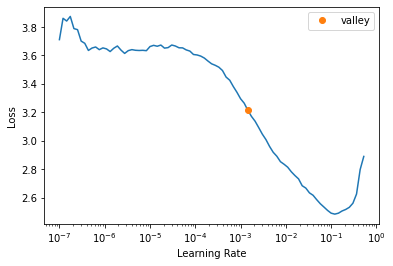

In [5]:
#dls = ImageDataLoaders.from_df(train_df,train_image_folder,item_tfms=Resize(28))
dls = ImageDataLoaders.from_folder(train_image_folder,valid_pct=0.2,seed=1024)
learn = cnn_learner(dls,models.resnet152) 
learn.lr_find()
learn.fine_tune(10)


In [6]:
test_paths = []
for i in range(0,28000):
    test_paths.append(Path(test_image_folder/(str(i)+'.png')))


In [7]:
dl = learn.dls.test_dl(test_paths)
preds = learn.get_preds(dl = dl)
preds   

(tensor([[4.2992e-08, 1.2377e-09, 1.0000e+00,  ..., 8.9454e-08, 1.0937e-08,
          2.2564e-08],
         [9.9999e-01, 2.7768e-07, 2.6632e-07,  ..., 1.5077e-06, 7.5343e-07,
          5.6342e-08],
         [2.9672e-07, 1.3823e-08, 1.1405e-06,  ..., 2.9904e-07, 1.3069e-06,
          1.0000e+00],
         ...,
         [4.4876e-10, 3.1235e-10, 3.5636e-09,  ..., 2.7611e-09, 4.3152e-09,
          7.1953e-10],
         [1.7376e-07, 7.5214e-09, 1.8646e-08,  ..., 4.2486e-08, 7.1598e-08,
          1.0000e+00],
         [1.1594e-08, 6.3180e-11, 1.0000e+00,  ..., 8.7920e-09, 2.4695e-09,
          3.6171e-09]]),
 None)

In [8]:
preds = preds[0].numpy().argmax(axis=1)

In [9]:
df_result = pd.DataFrame()
df_result['ImageId'] = range(1,28001)
df_result['Label'] = preds
df_result.head(20)
df_result.to_csv('./res152fit10.csv',header=True,index=False)

In [10]:
'''def pred_test(data_np,leaner,name):
    n_data_df = len(data_np)
    preds =[]
    for i in range(0,n_data_df):
        np_temp = np.uint8(data_np[i][:].reshape((28,28)))
        pre = leaner.predict(np_temp)
        pre = int(pre[0])
        preds.append(pre)
        print(name+" "+str(i)+' in '+str(n_data_df))
    return preds
    '''

'def pred_test(data_np,leaner,name):\n    n_data_df = len(data_np)\n    preds =[]\n    for i in range(0,n_data_df):\n        np_temp = np.uint8(data_np[i][:].reshape((28,28)))\n        pre = leaner.predict(np_temp)\n        pre = int(pre[0])\n        preds.append(pre)\n        print(name+" "+str(i)+\' in \'+str(n_data_df))\n    return preds\n    '

In [11]:
'''class PredThread(threading.Thread):
    def __init__(self, func, args=()):  
        super(PredThread, self).__init__()  
        self.func = func  
        self.args = args
    def run(self):  
        self.result = self.func(*self.args)  # 在执行函数的同时，把结果赋值给result,  
        # 然后通过get_result函数获取返回的结果  
    def get_result(self):  
        try:  
            return self.result  
        except Exception as e:  
            return None  
            '''

'class PredThread(threading.Thread):\n    def __init__(self, func, args=()):  \n        super(PredThread, self).__init__()  \n        self.func = func  \n        self.args = args\n    def run(self):  \n        self.result = self.func(*self.args)  # 在执行函数的同时，把结果赋值给result,  \n        # 然后通过get_result函数获取返回的结果  \n    def get_result(self):  \n        try:  \n            return self.result  \n        except Exception as e:  \n            return None  \n            '

In [12]:
'''start_time = time.time()
result = []  
threads = []
#learn.export()
for i in range(16):  
    learn_temp = load_learner(train_image_folder/'export.pkl',cpu=False)
    #learn_temp = copy(learn)
    name = 'Thread'+str(i)
    t = PredThread(pred_test, args=(test_df.to_numpy()[int(m_test*i/16):int(m_test*(i+1)/16)][:],learn_temp,name))  
    t.start()  
    threads.append(t)  
for t in threads:  
    t.join()  # 一定执行join,等待子进程执行结束，主进程再往下执行  
    result.append(t.get_result())  
print(result) 
end_time = time.time()
print(end_time-start_time)'''

"start_time = time.time()\nresult = []  \nthreads = []\n#learn.export()\nfor i in range(16):  \n    learn_temp = load_learner(train_image_folder/'export.pkl',cpu=False)\n    #learn_temp = copy(learn)\n    name = 'Thread'+str(i)\n    t = PredThread(pred_test, args=(test_df.to_numpy()[int(m_test*i/16):int(m_test*(i+1)/16)][:],learn_temp,name))  \n    t.start()  \n    threads.append(t)  \nfor t in threads:  \n    t.join()  # 一定执行join,等待子进程执行结束，主进程再往下执行  \n    result.append(t.get_result())  \nprint(result) \nend_time = time.time()\nprint(end_time-start_time)"

In [13]:
'''start_time = time.time()
preds = []
for i in range(0,m_test):
    np_temp = np.uint8(test_df.to_numpy()[i][:].reshape((28,28)))
    pre = learn.predict(np_temp)
    pre = int(pre[0])
    preds.append(pre)
    print(str(i)+' in 28000')
preds
end_time = time.time()
print(end_time-start_time)
'''

"start_time = time.time()\npreds = []\nfor i in range(0,m_test):\n    np_temp = np.uint8(test_df.to_numpy()[i][:].reshape((28,28)))\n    pre = learn.predict(np_temp)\n    pre = int(pre[0])\n    preds.append(pre)\n    print(str(i)+' in 28000')\npreds\nend_time = time.time()\nprint(end_time-start_time)\n"